In [1]:
corpus1_urls = [
'https://raw.githubusercontent.com/peterverhaar/dmt-2024/refs/heads/main/Assignment4/Corpus/a_tale_of_two_cities.txt',
'https://raw.githubusercontent.com/peterverhaar/dmt-2024/refs/heads/main/Assignment4/Corpus/david_copperfield.txt',
'https://raw.githubusercontent.com/peterverhaar/dmt-2024/refs/heads/main/Assignment4/Corpus/hard_times.txt',
'https://raw.githubusercontent.com/peterverhaar/dmt-2024/refs/heads/main/Assignment4/Corpus/oliver_twist.txt',
'https://raw.githubusercontent.com/peterverhaar/dmt-2024/refs/heads/main/Assignment4/Corpus/the_pickwick_papers.txt'
]
corpus1_label = 'Dickens'

corpus2_urls = [
'https://raw.githubusercontent.com/peterverhaar/dmt-2024/refs/heads/main/Assignment4/Corpus/emma.txt',
'https://raw.githubusercontent.com/peterverhaar/dmt-2024/refs/heads/main/Assignment4/Corpus/mansfield_park.txt',
'https://raw.githubusercontent.com/peterverhaar/dmt-2024/refs/heads/main/Assignment4/Corpus/northanger_abbey.txt',
'https://raw.githubusercontent.com/peterverhaar/dmt-2024/refs/heads/main/Assignment4/Corpus/persuasion.txt',
'https://raw.githubusercontent.com/peterverhaar/dmt-2024/refs/heads/main/Assignment4/Corpus/sense_and_sensibility.txt' 
]

corpus2_label = 'Austen'

In [2]:
import requests
import os
import re
from os.path import basename

directory = 'Corpus'

if not os.path.exists(directory):
    os.makedirs(directory)
    

def download(url):
    response = requests.get(url)
    if response:
        file_name = basename(url)
        out = open(file_name,'w',encoding='utf-8')
        out.write(response.text)
        out.close()
        
def download_to_corpus(url):
    response = requests.get(url)
    if response:
        file_name = basename(url)
        path = os.path.join(directory,file_name)
        out = open(path,'w',encoding='utf-8')
        out.write(response.text)
        out.close()
        
def find_title(file_name):
    title = basename(file_name)
    title = re.sub('%20',' ',title)
    title = re.sub(r'\'','',title)
    title = re.sub('.txt$','',title.strip())
    return title    

def clean_wordlist(words):
    words = [word for word in words if word not in string.punctuation]
    words = [word for word in words if word not in stopwords]
    words = [re.sub(r'([….])|(\')','',word) for word in words]
    words = [word for word in words if re.search(r'\w', word)]
    return words

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

        
import sys
!pip install vaderSentiment
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('punkt_tab')
        
        
download('https://raw.githubusercontent.com/peterverhaar/dmt-2024/refs/heads/main/Assignment3/text_mining.py')

for url in corpus1_urls:
    download_to_corpus(url)
    
for url in corpus2_urls:
    download_to_corpus(url)
    
    
out = open('metadata.csv','w',encoding='utf-8')
out.write('text,category\n')
for url in corpus1_urls:
    out.write(f"{find_title(basename(url))},{corpus1_label}\n")
for url in corpus2_urls:
    out.write(f"{find_title(basename(url))},{corpus2_label}\n")

out.close()


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/verhaarpaf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/verhaarpaf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/verhaarpaf/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/verhaarpaf/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/verhaarpaf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/verhaarpaf/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
import requests
import re
import os
import string
string.punctuation += '-•“”’– '
from text_mining import *

from os.path import join

from nltk import word_tokenize,sent_tokenize,pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

stopwords = stopwords.words('english')

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
ana = SentimentIntensityAnalyzer()


In [4]:
corpus = os.listdir(directory)
corpus = [os.path.join(directory,text) for text in corpus if re.search(r'txt$',text) and not(re.search(r'lemma',text))]

for text in corpus:
    print(text)
    
metadata = pd.read_csv('metadata.csv')

Corpus/mansfield_park.txt
Corpus/sense_and_sensibility.txt
Corpus/oliver_twist.txt
Corpus/david_copperfield.txt
Corpus/hard_times.txt
Corpus/northanger_abbey.txt
Corpus/persuasion.txt
Corpus/emma.txt
Corpus/the_pickwick_papers.txt
Corpus/a_tale_of_two_cities.txt


## Linguistic features

For each text, the number of characters, the number of words and the number of sentences are calculated. Using these data, we can compare the avarage word lengths and the average sentence lengths of all the novels. 

In [5]:
data = []

for file in corpus:
    print(f'Analysing {file} ... ')
    row = []
    text = open(file,encoding='utf-8')
    full_text = text.read()
    
    # Calculate number of characters (without spaces)
    full_text_no_spaces = re.sub( r'\s','',full_text)
    nr_characters = len(full_text)
    
    # Calculate number of words
    words = word_tokenize(full_text.lower())
    words = remove_punctuation(words)
    nr_tokens = len(words)
    
    avg_word_length = nr_characters / nr_tokens
    
    row.append(nr_tokens)
    row.append(nr_characters)
    row.append(avg_word_length)
    
    sentences = sent_tokenize(full_text)
    nr_sentences = len(sentences)
    row.append(nr_sentences)
    avg_sent_length = nr_tokens/nr_sentences
    
    row.append(avg_sent_length)
    
    first_2000 = words[:2000]
    unique = list(set(first_2000))
    ttr = len(unique)/len(first_2000)
    row.append(ttr)
    
    row.append(find_title(file))
    category = metadata.query( f"text=='{find_title(file)}' " )['category'].values[0]
    row.append(category)
    data.append(row)
    
columns = ['nr_tokens','nr_characters','word_length','nr_sentences','words_per_sentence','ttr','title','category']
df = pd.DataFrame(data, columns = columns)

Analysing Corpus/mansfield_park.txt ... 
Analysing Corpus/sense_and_sensibility.txt ... 
Analysing Corpus/oliver_twist.txt ... 
Analysing Corpus/david_copperfield.txt ... 
Analysing Corpus/hard_times.txt ... 
Analysing Corpus/northanger_abbey.txt ... 
Analysing Corpus/persuasion.txt ... 
Analysing Corpus/emma.txt ... 
Analysing Corpus/the_pickwick_papers.txt ... 
Analysing Corpus/a_tale_of_two_cities.txt ... 


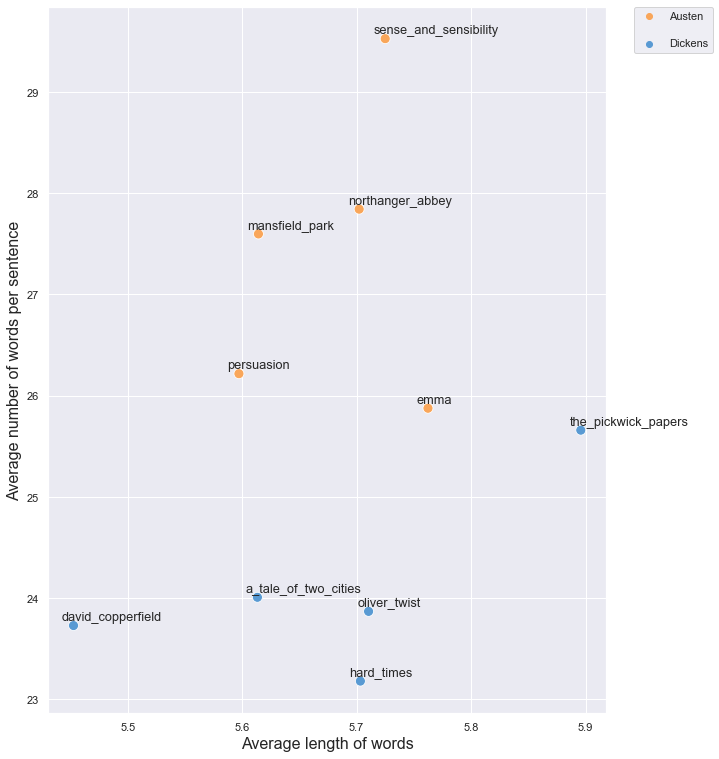

In [6]:
x_axis = 'word_length'
y_axis =  'words_per_sentence'
hue = 'category'

colours = ['#f9a65a','#599ad3']

fig = plt.figure( figsize = ( 10,13 ))

## This line adds spacing in between the lines of the legend 
sns.set(rc = {'legend.labelspacing': 1.6})

ax = sns.scatterplot( data=df, x=x_axis, y=y_axis,  
                     hue = hue,  palette=colours ,  s=100 )

for index, row in df.iterrows():
    plt.text( row[x_axis]-0.01, row[y_axis]+0.05 , row['title'] , fontsize=12.8)


ax.set_xlabel( 'Average length of words'  , fontsize = 16 )
ax.set_ylabel( 'Average number of words per sentence'  , fontsize = 16 )
#ax.set_title( '' , fontsize=24 )
plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);

plt.savefig( 'scatterplot.png' , dpi=300 )

## Type-token ratio

The type-token ratio can be calculated by dividing the number of unique words (the types) by the total number of words (the tokens). The number gives [an indication of the lexical diversity](https://cdsleiden.github.io/tdm-tutorial/notebooks/5%20Type-token_ratio.html). 

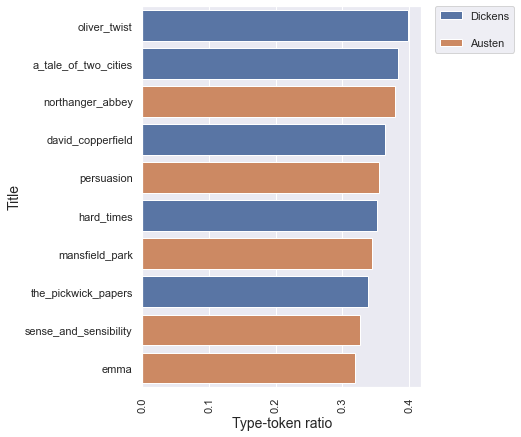

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

x_axis = 'ttr'
y_axis = 'title'
hue = 'category'

colours = ['#599ad3','#f9a65a']

fig = plt.figure( figsize=( 5,7 ) )

df_sorted = df.sort_values(by=[ x_axis] , ascending = False)

graph = sns.barplot( data=df_sorted , x=x_axis, y=y_axis, 
                   hue = hue , dodge = False)

#graph.set_title('' , size = 20) 
graph.set_xlabel('Type-token ratio' , size = 14) 
graph.set_ylabel('Title' , size = 14 )

plt.xticks(rotation= 90)

plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);

plt.show()

## Most frequent words

The words have been lemmatised first.

In [8]:
for file in os.listdir(directory):
    if re.search( 'lemma.txt',file ):
        path = os.path.join(directory,file)
        with open(path,encoding='utf') as fh:
            full_text = fh.read()
            words = word_tokenize(full_text.lower())
            # stopwords and punctuation is removed
            words = clean_wordlist(words)
            freq = Counter(words)
            key = re.sub('_lemma','',path)
            print(f"\n{find_title(key)}\n")
            for word,count in freq.most_common(15):
                print(f'{word} ({count})')



oliver_twist

say (1472)
mr (1077)
oliver (861)
look (463)
old (455)
come (447)
reply (423)
know (415)
bumble (396)
take (389)
man (387)
go (378)
make (372)
time (371)
gentleman (366)

sense_and_sensibility

elinor (679)
say (600)
marianne (562)
mrs (526)
know (367)
think (327)
sister (315)
make (304)
much (290)
give (286)
see (268)
time (257)
edward (256)
well (255)
dashwood (249)

emma

mr (1117)
say (857)
emma (826)
mrs (681)
think (643)
miss (591)
know (505)
harriet (481)
much (473)
thing (448)
well (433)
weston (432)
make (409)
come (389)
elton (383)

hard_times

say (938)
mr (654)
bounderby (535)
know (425)
mrs (388)
go (387)
come (323)
gradgrind (312)
sparsit (294)
make (274)
look (271)
louisa (265)
take (239)
sir (233)
see (231)

northanger_abbey

catherine (485)
say (324)
think (242)
go (233)
tilney (218)
know (208)
miss (206)
well (186)
make (179)
mrs (175)
much (169)
time (160)
mr (160)
never (158)
general (154)

the_pickwick_papers

mr (5747)
say (3982)
pickwick (2372)
sir

## Unique words

In [9]:
categories = list(metadata['category'].unique())

corpus1 = []
corpus2 = []
corpus1_freq = Counter()
corpus2_freq = Counter()

for text in corpus:
    category = metadata.query( f"text=='{find_title(text)}' " )['category'].values[0]
    if category == categories[0]:
        corpus1.append(text)
    else:
        corpus2.append(text)

for text in corpus1:
    file = open(text,encoding='utf-8')
    full_text = file.read()
    words = word_tokenize(full_text.lower())
    words = remove_punctuation_and_stopwords(words)
    corpus1_freq.update(words)

    
for text in corpus2:
    file = open(text,encoding='utf-8')
    full_text = file.read()
    words = word_tokenize(full_text.lower())
    words = remove_punctuation_and_stopwords(words)
    corpus2_freq.update(words)

In [10]:
print(f'The list below indicates the 20 most frequent words in the {categories[0]} subcorpus.\n')

for word,count in corpus1_freq.most_common(20):
    print(f'{word} => {count}')

The list below indicates the 20 most frequent words in the Dickens subcorpus.

said => 8883
one => 2828
would => 2559
little => 2482
upon => 2464
pickwick => 2352
old => 2308
sir => 2257
man => 2213
could => 2026
know => 2012
time => 1878
replied => 1713
never => 1621
say => 1570
much => 1540
well => 1522
come => 1500
good => 1479
see => 1452


In [11]:
print(f'The list below indicates the 20 most frequent words in the {categories[1]} subcorpus.\n')

for word,count in corpus2_freq.most_common(20):
    print(f'{word} => {count}')

The list below indicates the 20 most frequent words in the Austen subcorpus.

could => 3061
would => 2751
must => 1749
said => 1603
much => 1581
miss => 1550
one => 1549
every => 1239
think => 1221
might => 1165
well => 1135
never => 1118
little => 1096
time => 1081
know => 1059
good => 1008
fanny => 963
nothing => 959
without => 871
say => 864


In [12]:
print(f'The following words from the {categories[0]} subcorpus are NEVER used in the {categories[1]} subcorpus\n')

for word,count in corpus1_freq.most_common():
    if word not in corpus2_freq.keys():
        print(word)

The following words from the Dickens subcorpus are NEVER used in the Austen subcorpus

pickwick
weller
micawber
peggotty
winkle
bounderby
copperfield
traddles
dora
agnes
steerforth
bumble
lorry
sikes
wery
murdstone
gradgrind
fagin
defarge
sparsit
bob
wardle
sawyer
uriah
snodgrass
perker
ly
wickfield
wot
pott
bardell
brownlow
davy
rachael
sammy
jingle
pross
heep
manette
barkis
eh
carton
trotwood
spenlow
sissy
darnay
noah
monks
harthouse
fogg
lucie
gen
creakle
r
cruncher
giles
mas
dodson
samuel
omer
monsieur
dodger
ben
wos
afore
serjeant
gummidge
mills
monseigneur
stryver
coketown
arabella
jerry
jip
beadle
maylie
charley
crupp
pell
tellson
trotter
punch
chin
commons
sowerberry
dartle
fur
annie
magnus
stiggins
wooden
nupkins
yer
remarked
david
jury
vith
jack
pound
wi
sydney
retorted
doen
desk
thee
dowler
chillip
jacques
paris
umble
bitzer
grimwig
arter
rubbing
th
twist
mell
benjamin
lobbs
lowten
raddle
corney
matron
sleary
thrust
bag
toby
spinster
mowcher
eatanswill
cluppins
maldon
theer


graced
explosive
commencing
masses
overshadowed
frantically
britain
flocked
toasts
bleed
commissioners
crockery
statistical
equestrian
congregated
stoppage
knuckled
mith
coriolanian
herein
fok
awa
stirrup
border
calculating
mittens
railroad
monny
sen
weel
beginnin
nickits
domestics
adjured
shrieking
messengers
h
describes
conviviality
gentry
wicker
spectral
towels
petitions
habited
vether
vait
vy
buffs
puttin
vithout
smorltork
feelin
kate
respectin
tadger
tomato
perpendicular
gorgeous
snuphanuph
lud
whiffers
accursed
flop
wigged
alexandre
believeth
goaded
continues
burglary
li
lii
liii
item
palms
chafed
blanket
offenders
choleric
delegate
beadles
cuff
festive
ranged
tingling
flogged
inserted
skull
starve
recreations
elastic
grovelling
snapping
victuals
tainted
leathers
deferential
promptness
atrocity
houseless
aperture
hoisted
sneak
sanguinary
designated
precedents
disputes
crawl
villages
beak
dissolute
balustrade
huddled
trap
miser
rolls
suffocation
accidently
untidy
meagre
onions
cov

bacchanalian
upshot
airily
phraseology
flickering
consume
trustful
puffs
limit
sow
alongside
legatee
executrix
floundering
chip
littlest
chay
foundered
fagging
whipped
branded
beefsteak
lull
radiance
constraining
holder
pernicious
celestial
pitted
howbeit
fountains
oasis
grape
patriarch
discouraging
dirge
dishonourable
betrothal
appointing
pitfalls
pitchers
siege
exacting
tottenham
conflagration
compounding
chivalrous
soonest
idiosyncrasy
appy
leering
repairs
mastery
provincial
brew
superstitious
boastfully
judicial
bumpers
legitimate
graminivorous
supremely
insanely
bandit
horrified
nerved
frugal
plank
expounded
bower
speakers
pitt
denunciations
chemists
bribe
commits
testamentary
petted
dustman
withdraws
conflicting
admiringly
rheumatics
propitiatory
hangman
upheld
fower
bereaved
harass
tucker
likings
translated
reunited
deferring
precept
sucked
jerks
besetting
undulating
flashes
devising
ignominy
cinders
oceans
mists
smear
revolve
imploringly
thrilled
settler
suggestive
spain
dootif

surwive
muffle
properiator
adopting
portmanteaus
precipitated
weaving
network
granddaughter
uproarious
incited
thereto
morsels
rebuke
fiddlers
jocosely
desisting
bakers
digestion
carol
scatters
jot
emblems
consorted
smelled
courtiers
goblet
atween
skate
reel
currently
bubbled
cracking
ourself
inferences
exhalations
rim
cabalistic
subpoena
nal
affectin
refresher
merrikins
turnin
watty
subpoenaed
sanctum
forensic
frownings
jobbing
revenues
tapper
parding
fierceness
ruffinly
slasher
croup
pacifically
luckless
drover
cads
wending
leadenhall
cannibal
valentine
squared
recline
constructing
actiwally
circumscribed
callin
fabulous
downhill
monthly
indefatigably
progenitor
penniless
lath
devotees
bobbed
ushers
noakes
greased
mudberry
bunkin
vociferated
spells
wirtuous
eulogiums
hooroar
sealskin
playin
whopped
symmetrical
incipient
glorwious
trump
promenading
promenade
leprosy
reaping
civilisation
potentate
perpetuating
embassy
minstrels
exaltation
diplomacy
athenian
ner
bronze
inclose
killibeat

hatchway
households
stools
ploughmen
tween
unsettlement
spar
cathedrals
solitudes
precipices
bases
gorge
stemming
avalanche
steeps
betrayal
contentions
frivolously
shadowing
quicksands
bricklayer
insalubrity
prescriptive
wainscoted
indomitable
rumpling
maddest
gratifies
cockboat
improvise
doe
dem
jipes
versus
wigziell
insatiably
endowment
defaulter
exactions
pounce
hoary
inaptly
claimants
tepid
grappled
tucks
bereavement
placidest
waived
phrenological
developments
slowest
miscall
potations
lunacy
unman
terrify
wedlock
tramps
briar
harmoniously
jarred
dislikings
entreatingly
betides
inexplicably
soundest
sooty
housewife
blunting
sleet
folios
averring
enjoyingly
capped
jewelled
fishmongers
batter
jobbed
unchallengeable
felonies
satires
massively
busier
legitimately
repasts
isolation
traverse
tougher
contractor
neophytes
adulteration
incautiously
immortally
warders
knowingest
immaculates
valuables
southampton
pounded
gamest
knaves
hobby
lonelier
slopes
supplanting
forsaken
ravelled
fortun

adjourning
covenanted
soldered
imports
unblotted
flicking
slipper
encourages
steeplechase
stud
overwalking
spike
shipwrecks
miscellany
duplicates
twitches
unsuspicion
snowstorm
ventilated
steams
houndsditch
beards
munch
dedicated
seediness
crispness
curiosities
opulent
jewish
omnibus
residences
chameleon
tweak
respired
pursed
horsing
freemasonry
erd
threepenn
remarkin
mace
rescuer
werdicks
learnedly
rattlin
marchioness
gradivally
subsekent
imbibes
succinctly
nixon
sixpenny
dressin
arrestin
sendin
wagabone
octavo
ledger
whiplashes
reachin
unconstitootional
blessedest
visperin
offensively
singin
metre
bess
gallops
bul
gul
likin
flank
spiteful
windictive
unremorseful
shou
vinter
aggrawation
tizer
waylay
persewerance
vaiter
occupyin
undeceivin
dewoured
fillin
tragical
changings
rented
bedding
vegetated
bristly
vastin
buildin
leavin
nevy
testator
collegians
eightpenny
deploringly
sniffed
melincholly
schoolmissus
velcome
orths
watcher
pollutes
platonic
teemed
aggrawated
regency
vite
vitevash

In [13]:
print(f'The following words from the {categories[1]} subcorpus are NEVER used in the {categories[0]} subcorpus\n')

for word,count in corpus2_freq.most_common():
    if word not in corpus1_freq.keys():
        print(word)

The following words from the Austen subcorpus are NEVER used in the Dickens subcorpus

fanny
elinor
crawford
marianne
catherine
harriet
weston
elton
knightley
woodhouse
elliot
bertram
dashwood
jennings
fairfax
wentworth
tilney
rushworth
churchill
willoughby
norris
mansfield
hartfield
thorpe
morland
brandon
walter
musgrove
ferrars
highbury
middleton
barton
cousins
randalls
palmer
eleanor
harville
uppercross
perry
kellynch
yates
lyme
benwick
goddard
croft
sotherton
norland
shew
campbell
portsmouth
donwell
chuse
frederick
taylor
musgroves
hayter
shewed
steele
northanger
dashwoods
bertrams
wallis
enscombe
surprize
shewn
steeles
surprized
maple
dalrymple
delaford
fullerton
cleveland
crofts
campbells
thornton
rebecca
eltons
stopt
woodston
shewing
tilneys
weymouth
middletons
charade
mortifying
allenham
udolpho
harvilles
baronet
curricle
agatha
hawkins
lacey
ireland
complaisance
exeter
combe
morton
harley
milsom
hughes
crawfords
everingham
anhalt
pulteney
vicarage
amelia
enquiries
cobb
northam

1st
protests
severed
enthusiast
unshackled
printshop
cockleshell
horsepond
blister
brand
sophys
minehead
unforgiving
molland
atkinson
discriminating
climes
frankland
deviated
contiguous
manœuvred
transposed
comprehensible
recommencing
unproductively
repossessed
gapes
abdication
incalculable
purification
enquirer
durands
unfledged
ibbotsons
maclean
fors
againsts
concealments
baronetcies
immethodical
wm
testimonies
oral
turnings
romancing
circumventing
manœuvres
opposer
favourer
disingenuous
inhumanity
incumbrances
recoverable
unperplexed
embargo
complicate
subtleties
forwardness
dimming
streightens
wriggles
superiorities
assorting
captiously
inadvertencies
misconstructions
recomposed
broodings
sultaness
granting
proverbs
calculates
undeviating
prophesied
gunsmith
repulsively
politicians
retrospections
retarding
governance
darings
felicitous
inaction
eligibilities
corrective
landaulette
headship
wheedled
transgressions
accessions
valetudinarian
bangs
broadway
drizzle
adoption
dissentient

## Dunning’s log likelihood

One of statistical methods that can be used to find such distinctive words is Dunning’s log likelihood. In short, it analyses the distinctiveness of word in one set of texts compared to the texts in a reference corpus, by calculating probabilities based on word frequencies. A good explanation of the fomula can be found on the [wordHoard](https://wordhoard.northwestern.edu/userman/analysis-comparewords.html#loglike) website.

Using the frequencies that have been calculated above, the Dunning log likelihood scores are calculated for all of the words that occur both in corpus1 and corpus2 in the cell below. The actual calculation takes place in a method named `log_likelihood()`. The scores that are calculated are all stored in a dictionary named ll_scores

The formula that is implemented in the log_likelihood method returns a number which can either be positive or negative. A postive score indicates that there is a high probability that the word will be used in the first corpus. A negative probability indicates that occurence of the word is more common in the second corpus. The tokens that are assigned the highest scores, in other words, are also most distincive of the first corpus.

The code below lists the words that are assigned a positive log likelihood score in the first corpus.

See also [TDM tutorial, chapter on Diction](https://cdsleiden.github.io/tdm-tutorial/notebooks/9%20Diction.html)

In [14]:
total1 = sum(corpus1_freq.values())
total2 = sum(corpus2_freq.values())

In [15]:
ll_scores = dict()


for word in corpus1_freq.keys():
    if word in corpus2_freq.keys():

        ll_score = log_likelihood( corpus1_freq[word] , corpus2_freq[word] , total1 , total2 )
        ll_scores[word] = ll_score

max = 25
i = 0 
        

In [16]:
print(f'The following words are most distinctive in the {categories[0]} subcorpus\n')


for word in sorted_by_value(ll_scores , ascending = False ):
    print( word , ll_scores[word] )
    i += 1
    if i == max: 
        break  

The following words are most distinctive in the Dickens subcorpus

said 2051.0988912128128
sam 919.172786111536
old 848.5527037830456
oliver 736.2536752390824
doctor 523.5431795907955
face 507.58438920078214
boy 496.5135588926823
gentleman 484.62280176904477
head 461.00192885613916
em 457.1308830448329
replied 449.86675123604766
hand 414.8789208911234
upon 411.19947641078124
inquired 322.7473831954588
night 285.44989084318007
tupman 272.00859855563493
jew 266.87506034550273
ha 260.5562618117829
master 245.8009646163694
hands 224.55017672472255
door 219.30226723212922
eyes 190.77877111464096
hat 183.19929742234729
rejoined 181.72677497479685
got 176.4950651253642


In [17]:
print(f'The following words are most distinctive in the {categories[1]} subcorpus\n')

max = 25
i = 0 

for word in sorted_by_value(ll_scores ) :
    print( word , ll_scores[word] )
    i += 1
    if i == max:
        break   

The following words are most distinctive in the Austen subcorpus

emma -1509.609409115036
could -1331.9750387738402
must -1008.7295332558633
anne -1004.6463565854916
edmund -841.2837634449467
would -626.2076706756661
every -611.5251745177957
miss -588.1630458297271
soon -538.6526505129832
sister -511.08009545844334
henry -499.2998904327387
edward -439.41887387788495
jane -422.66130692471677
isabella -407.44103439994285
captain -394.1578582861483
colonel -380.977538808964
mrs -378.00355656130347
lucy -376.7983941814167
feelings -363.04215241886965
thomas -362.92478229658974
john -362.27634370240185
frank -360.89974285163436
however -329.2341492895442
much -320.05401779666624
smith -306.547353870227


## Bigrams

In [19]:
import nltk
from nltk.util import ngrams

bigrams = Counter()

for text in corpus1:
    file = open(text,encoding='utf-8')
    full_text = file.read()
    words = word_tokenize(full_text.lower())
    words = remove_punctuation_and_stopwords(words)
    n_grams = ngrams(words, 2)
    bigrams.update([ ' '.join(grams) for grams in n_grams])
    
for bigram,count in bigrams.most_common(19):
    print(f"{bigram} => {count}")

said pickwick => 587
sir said => 503
old gentleman => 319
said sam => 315
sir replied => 292
said aunt => 223
young lady => 214
bob sawyer => 210
old lady => 208
em ly => 202
miss murdstone => 179
well said => 175
said old => 175
dear said => 169
young man => 169
said peggotty => 168
said micawber => 167
said weller => 162
dear sir => 158


In [20]:
bigrams = Counter()

for text in corpus2:
    file = open(text,encoding='utf-8')
    full_text = file.read()
    words = word_tokenize(full_text.lower())
    words = remove_punctuation_and_stopwords(words)
    n_grams = ngrams(words, 2)
    bigrams.update([ ' '.join(grams) for grams in n_grams])
    
for bigram,count in bigrams.most_common(19):
    print(f"{bigram} => {count}")

sir thomas => 327
miss crawford => 263
every thing => 199
captain wentworth => 194
great deal => 187
young man => 180
mr elliot => 174
miss woodhouse => 157
dare say => 154
lady russell => 146
every body => 143
frank churchill => 141
lady bertram => 132
sir walter => 129
colonel brandon => 127
miss fairfax => 119
sir john => 111
miss bates => 108
jane fairfax => 100


## Part of Speech tagging and Lemmatisation

In [ ]:


data = []
all_novels = []
lemmatiser = WordNetLemmatizer()

# Dictionaries to save all nouns, adjectives, adverbs and nouns 
all_adj_adv_noun = dict()
all_verbs = dict()

adj_noun_pos = ['JJ','JJR','RB','RDR','RBS','NN','NNS','NNP']
verbs_pos = ['VB','VBD','VBG','VBN']

# Dictionary to save number of tokens
nr_tokens = dict()

for file in corpus:
    lemmatised = ''
    pos_tags = dict()

    # Pos categories in the current text
    adj_adv_noun = []
    verbs = []
    
    count_tokens = 0
    
    out_file = re.sub( r'\.txt$' , '_lemma.txt', file)
    
    print(f'Analysing {file} ... ')

    text = open(file,encoding='utf-8')
    full_text = text.read()
    sentences = sent_tokenize(full_text)
    
    for sentence in sentences:
        words = word_tokenize(sentence)
        words = clean_wordlist(words)
        pos = pos_tag(words)

        for i,word in enumerate(words):
            word = word.lower()

            pos_tags[pos[i][1]] = pos_tags.get(pos[i][1],0)+1
                       
            posTag = ptb_to_wordnet( pos[i][1] )
            if re.search( r'\w+' , posTag , re.IGNORECASE ):
                lemma = lemmatiser.lemmatize( words[i] , posTag )
                lemmatised += lemma + ' '
                count_tokens += 1
                
                if len(lemma)>0:
                
                    if pos[i][1] in adj_noun_pos:
                        adj_adv_noun.append(lemma.lower())
                    if pos[i][1] in verbs_pos:
                        verbs.append(lemma.lower())

        lemmatised += '\n'
    
    all_adj_adv_noun[file] = adj_adv_noun
    all_verbs[file] = verbs
    nr_tokens[file] = count_tokens
    all_novels.append(file)
        
    with open(out_file,'w',encoding='utf-8') as out:
        out.write(lemmatised)
        
    
    total = sum(pos_tags.values())
    row = []
    row.append(find_title(file))
    category = metadata.query( f"text=='{find_title(file)}' " )['category'].values[0]
    row.append(category)
    row.append(pos_tags.get('MD',0)/total)
    row.append(pos_tags.get('FW',0)/total)
    row.append(pos_tags.get('JJ',0)/total)
    row.append((pos_tags.get('JJR',0)+pos_tags.get('JJS',0))/total)
    row.append(pos_tags.get('RB',0)/total)
    row.append((pos_tags.get('RBR',0)+pos_tags.get('RBS',0))/total)
    data.append(row)

df_pos = pd.DataFrame(data,columns=['title','category','modal_verb','foreign_word','adj','adj-comp-super','adv','adv-comp-super'])


In [ ]:
df_pos['modal_verb'] = df_pos['modal_verb']*100

fig = plt.figure( figsize=( 8,5 ) )


graph = sns.barplot( data=df_pos,x='title', y='modal_verb', 
                   hue = 'category', dodge = False)

#graph.set_title('' , size = 20) 
graph.set_xlabel('Title' , size = 14) 
graph.set_ylabel('Percentage of modal verbs' , size = 14 )

plt.xticks(rotation=80)
plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);
plt.show()

In [ ]:
df_pos['foreign_word'] = df_pos['foreign_word']*100

fig = plt.figure( figsize=( 8,5 ) )


graph = sns.barplot( data=df_pos,x='title', y='foreign_word', 
                    hue = 'category' , dodge = False )

#graph.set_title('' , size = 20) 
graph.set_xlabel('Title' , size = 14) 
graph.set_ylabel('Percentage of foreign words' , size = 14 )

plt.xticks(rotation=80)
plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);
plt.show()

In [ ]:
df_pos['adj-comp-super'] = df_pos['adj-comp-super']*100
df_pos['adj'] = df_pos['adj']*100
df_pos['adv-comp-super'] = df_pos['adv-comp-super']*100
df_pos['adv'] = df_pos['adv']*100

In [ ]:
fig = plt.figure( figsize = ( 8,8 ))

x_axis='adj'
y_axis='adj-comp-super'

## This line adds spacing in between the lines of the legend 
sns.set(rc = {'legend.labelspacing': 1.6})

ax = sns.scatterplot( data=df_pos, x=x_axis, y=y_axis,  
                     hue = 'category',  s=100 )

for index, row in df_pos.iterrows():
    plt.text( row[x_axis], row[y_axis], row['title'] , fontsize=12.8)

ax.set_xlabel( 'Adjectives in regular form'  , fontsize = 16 )
ax.set_ylabel( 'Adjectives in the comparative or superlative form'  , fontsize = 16 )
#ax.set_title( '' , fontsize=24 )
plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);
plt.show()

In [ ]:
fig = plt.figure( figsize = ( 8,8 ))

x_axis='adv'
y_axis='adv-comp-super'

## This line adds spacing in between the lines of the legend 
sns.set(rc = {'legend.labelspacing': 1.6})

ax = sns.scatterplot( data=df_pos, x=x_axis, y=y_axis,  
                     hue='category',  s=100 )

for index, row in df_pos.iterrows():
    plt.text( row[x_axis], row[y_axis] , row['title'] , fontsize=12.8)


ax.set_xlabel( 'Adverbs in regular form'  , fontsize = 16 )
ax.set_ylabel( 'Adverbs in the comparative or superlative form'  , fontsize = 16 )
#ax.set_title( '' , fontsize=24 )
plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);
plt.show()

## Hypernyms

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def wordnet_hypernyms(token):
    all_hypernyms = []
    black_list = ['queen','young','human']
    
    if token not in black_list:
        
        word_senses = wn.synsets(token)

        hypernyms = lambda s: s.hypernyms()

        return_value = False

        for ws in word_senses:

            hypernyms = [hyp.name() for hyp in list(ws.closure(hypernyms))]

            if 'plant.n.02' in hypernyms:
                all_hypernyms.append('plant')
            if 'color.n.01' in hypernyms:
                all_hypernyms.append('colour')
            if 'emotion.n.01' in hypernyms:
                all_hypernyms.append('emotion')
            if 'animal.n.01' in hypernyms:
                all_hypernyms.append('animal')
            if 'natural_phenomenon.n.01' in hypernyms:
                all_hypernyms.append('natural_phenomenon')
            if 'body_part.n.01' in hypernyms:
                all_hypernyms.append('body_part')
                                    
    return all_hypernyms

for file in os.listdir(directory):
    
    if re.search( 'lemma.txt',file ):
        data = []
        
        key = os.path.join(directory,re.sub('_lemma','',file))
        title = find_title(key)
        path = os.path.join(directory,file)
        with open(path,encoding='utf') as fh:
            full_text = fh.read()
            words = word_tokenize(full_text.lower())
            words = clean_wordlist(words)
            freq = Counter(words)

            for word,count in freq.most_common():
                hypernyms = wordnet_hypernyms(word)
                if len(hypernyms)>0:
                    for h in hypernyms:
                        row = []
                        row.append(word)
                        row.append(h)
                        row.append(count)
                        data.append(row)
                        
        df = pd.DataFrame(data,columns=['word','domain','count'])
                        
                        

        x_axis = list(df.groupby('domain')['count'].sum().to_dict().values())
        # normalise values
        x_axis = [(value/nr_tokens[key])*100 for value in x_axis]
        y_axis = list(df.groupby('domain')['count'].sum().to_dict().keys())
                                
        colours = ['#599ad3','#f9a65a']

        fig = plt.figure( figsize=( 10,4 ) )

        graph = sns.barplot( x=x_axis, y=y_axis, 
                            color = '#3b83d1' , dodge = False)

        graph.set_title(title , size = 20) 
        graph.set_xlabel('Type-token ratio' , size = 14) 
        graph.set_ylabel('Title' , size = 14 )
        
        graph.set_xlim(0,4)


        plt.xticks(rotation= 90)

        plt.show()
        
        print(f'\n\nMost common emotions in "{find_title(key)}"\n')
        
        count = 0
        for i,row in df.query(' domain=="emotion" ').sort_values(by='count',ascending=False).iterrows():
            print(f"{row['word']} ({row['count']})" , end= '; ' )
            count += 1
            if count==15:
                break
                
        print(f'\n\nMost common colours in "{find_title(key)}"\n')
        
        count = 0
        for i,row in df.query(' domain=="colour" ').sort_values(by='count',ascending=False).iterrows():
            print(f"{row['word']} ({row['count']})" , end= '; ' )
            count += 1
            if count==15:
                break
        
        print(f'\n\nMost common body_parts in "{find_title(key)}"\n')
        
        count = 0
        for i,row in df.query(' domain=="body_part" ').sort_values(by='count',ascending=False).iterrows():
            print(f"{row['word']} ({row['count']})" , end= '; ' )
            count += 1
            if count==15:
                break
        
        
        print(f'\n\nMost common natural phenomena in "{find_title(key)}"\n')
        
        count = 0
        for i,row in df.query(' domain=="natural_phenomenon" ').sort_values(by='count',ascending=False).iterrows():
            print(f"{row['word']} ({row['count']})" , end= '; ' )
            count += 1
            if count==15:
                break
        
        print(f'\n\nMost common animals in "{find_title(key)}"\n')
        
        count = 0
        for i,row in df.query(' domain=="animal" ').sort_values(by='count',ascending=False).iterrows():
            print(f"{row['word']} ({row['count']})" , end= '; ' )
            count += 1
            if count==15:
                break
                

## Sentiment analysis

In [ ]:

def average_score(file):
    all_scores = []
    file = open( file , encoding = 'utf-8' )
    full_text = file.read()
    sentences = sent_tokenize( full_text )
    for s in sentences:
        scores = ana.polarity_scores(s)
        all_scores.append( scores["pos"] )
    return sum(all_scores)/len(all_scores)
        
sent_scores = dict()

for text in corpus:

    avg_score = average_score(text)
    sent_scores[text]=avg_score
    
    
x_axis = list(sent_scores.keys())
y_axis = list(sent_scores.values())

x_axis = [find_title(text) for text in x_axis]

fig = plt.figure( figsize=( 10,4 ) )

graph = sns.barplot( x=x_axis, y=y_axis, 
                    color = '#3b83d1' , dodge = False )

#graph.set_title( '' , size = 20) 
graph.set_xlabel('Title' , size = 14 )
graph.set_ylabel('Average sentiment scores' , size = 14) 


plt.xticks(rotation= 80)

plt.show()